In [16]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.utils as utils
from   tensorflow.keras.preprocessing.image import ImageDataGenerator
from   tensorflow.keras.models import Sequential
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, ZeroPadding2D
from   tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from   tensorflow.keras.utils import plot_model
from   tensorflow.keras.callbacks import ModelCheckpoint
from   pathlib import Path
from   tensorflow.keras import models, layers, optimizers
from   sklearn.utils.class_weight import compute_class_weight

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os
import random
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

In [6]:
# import zipfile
# import os

# def unzip_and_save(zip_file, extract_dir):
#     with zipfile.ZipFile(zip_file, 'r') as zip_ref:
#         zip_ref.extractall(extract_dir)

# # Example usage
# zip_file_path = 'Dataset Trash.zip'
# extract_dir = 'data'

# unzip_and_save(zip_file_path, extract_dir)


# Preprocessing

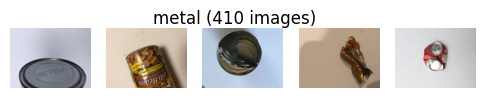

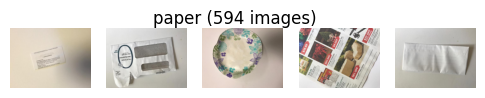

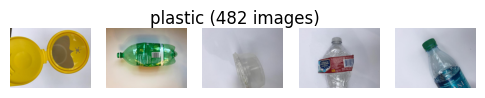

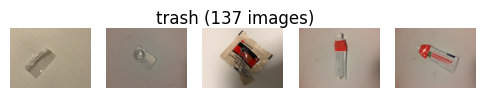

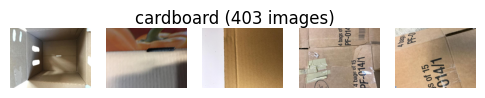

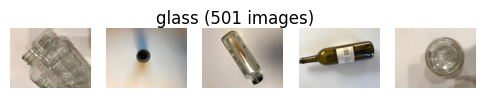

In [7]:
import matplotlib.pyplot as plt
from pathlib import Path
import random
import cv2

# Path to your dataset folder
dataset_path = Path("TrashType_Image_Dataset")
image_list = list(dataset_path.glob("*/*.jpg"))

# Shuffle the image list
random.shuffle(image_list)

# List the class folders
class_folders = [folder.name for folder in dataset_path.iterdir() if folder.is_dir()]

# Dictionary to store the count of images in each class
class_counts = {}

# Define the number of images to display for each class
num_images_per_class = 5

# Loop through each class folder
for class_folder in class_folders:
    class_path = dataset_path / class_folder

    # List all image files in the class folder
    image_files = list(class_path.glob("*.jpg"))

    # Count the number of images in the class
    num_images = len(image_files)

    # Store the count in the dictionary
    class_counts[class_folder] = num_images

    # Randomly select 5 images from the class
    selected_images = random.sample(image_files, min(num_images_per_class, num_images))

    # Display the images
    plt.figure(figsize=(6, 1))
    plt.suptitle(f"{class_folder} ({num_images} images)")
    for i, image_path in enumerate(selected_images, 1):
        image = plt.imread(image_path)
        plt.subplot(1, num_images_per_class, i)
        plt.imshow(image)
        plt.axis('off')
    plt.show()


In [8]:
# Image Preprocessing

for image_path in image_list:
    img = cv2.imread(str(image_path))


    # Reduce Noises with Gaussian blur
    blur = cv2.GaussianBlur(img, (3, 3), 0)

    # Replace images
    cv2.imwrite(str(image_path), blur)

# Split Train and Test datas

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_data_generators(train_data_dir, test_data_dir, img_size, batch_size):
    train_img_generator = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.2,
        width_shift_range=0.4,
        height_shift_range=0.4,
        rotation_range=20,
        shear_range=0.3,
        fill_mode='nearest'
    )

    test_img_generator = ImageDataGenerator(rescale=1./255)

    train_generator = train_img_generator.flow_from_directory(
        train_data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='training'  # Use the training subset for training data
    )

    validation_generator = train_img_generator.flow_from_directory(
        train_data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        subset='validation'  # Use the validation subset for validation data
    )

    test_generator = test_img_generator.flow_from_directory(
        test_data_dir,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Don't shuffle test data
    )

    return train_generator, validation_generator, test_generator

# Example usage
train_data_dir = dataset_path
test_data_dir = dataset_path
img_size = (180, 180)  # Example image size
batch_size = 32  # Example batch size

train_generator, validation_generator, test_generator = create_data_generators(train_data_dir, test_data_dir, img_size, batch_size)


Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.
Found 2527 images belonging to 6 classes.


In [10]:
import pandas as pd

def extract_filenames_labels(generator):
    filenames = generator.filenames
    labels = generator.classes
    return filenames, labels

# Extract filenames and labels from the generators
train_filenames, train_labels = extract_filenames_labels(train_generator)
val_filenames, val_labels = extract_filenames_labels(validation_generator)
test_filenames, test_labels = extract_filenames_labels(test_generator)

# Create DataFrames
train_df = pd.DataFrame({'filename': train_filenames, 'label': train_labels})
val_df = pd.DataFrame({'filename': val_filenames, 'label': val_labels})
test_df = pd.DataFrame({'filename': test_filenames, 'label': test_labels})

# Optionally, save the DataFrames to CSV files
train_df.to_csv('train_df.csv', index=False)
val_df.to_csv('val_df.csv', index=False)
test_df.to_csv('test_df.csv', index=False)


In [11]:
def build_model(num_classes):
    # Loading pre-trained ResNet model
    base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)

    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    base_model.trainable = False

    return model

model = build_model(num_classes=6)

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=[tf.keras.metrics.categorical_accuracy])

model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [12]:
# Model training

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30
)

Epoch 1/30
64/64 [==============================] - 38s 470ms/step - loss: 1.4426 - categorical_accuracy: 0.3938 - val_loss: 1.2378 - val_categorical_accuracy: 0.5169
Epoch 2/30
64/64 [==============================] - 26s 402ms/step - loss: 1.1898 - categorical_accuracy: 0.5173 - val_loss: 1.1386 - val_categorical_accuracy: 0.5765
Epoch 3/30
64/64 [==============================] - 25s 399ms/step - loss: 1.0627 - categorical_accuracy: 0.5845 - val_loss: 1.1154 - val_categorical_accuracy: 0.6083
Epoch 4/30
64/64 [==============================] - 26s 400ms/step - loss: 1.0017 - categorical_accuracy: 0.6151 - val_loss: 1.0595 - val_categorical_accuracy: 0.5666
Epoch 5/30
64/64 [==============================] - 26s 400ms/step - loss: 0.9664 - categorical_accuracy: 0.6374 - val_loss: 1.0457 - val_categorical_accuracy: 0.6103
Epoch 6/30
64/64 [==============================] - 26s 400ms/step - loss: 0.9262 - categorical_accuracy: 0.6556 - val_loss: 0.9617 - val_categorical_accuracy: 0.648

In [18]:
# Accuracy

acc = accuracy_score(test_generator.classes, y_pred)
print("Accuracy is {} percent".format(round(acc*100,2)))


Accuracy is 81.08 percent


79/79 [==============================] - 7s 85ms/step
Confusion Matrix


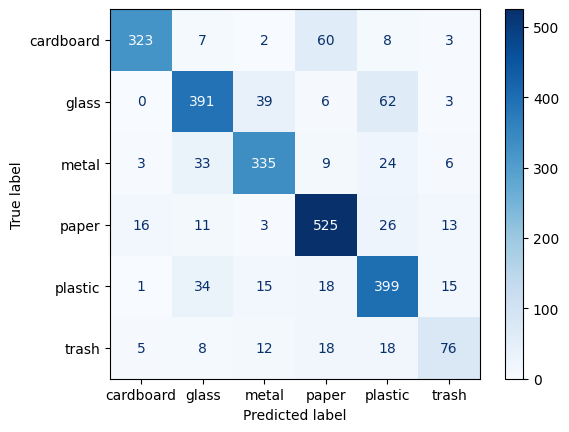

In [17]:
# Confusion Matrix

y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, y_pred)
labels = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()